# Benchmark: Koalas (PySpark) and Dask - Distributed execution summary

The benchmark was performed against the 2009 - 2013 Yellow Taxi Trip Records (157 GB) from NYC Taxi and Limousine Commission (TLC) Trip Record Data.

The benchmark results below explain the performance differences between Koalas and Dask. Because the Koalas APIs are written on the top of PySpark, the results of this benchmark would apply similarly to PySpark.

### Preparation

In [0]:
import pandas as pd
from scipy import stats 

def fair_avg(durations):
  """Get an average duration among multiple durations fairly by removing the first run and the best run first."""
  durations = durations[1:]
  durations.remove(min(durations))
  return sum(durations) / len(durations)

def rename_index(df):
  """Rename operations in the average result dataframe for clarity."""
  df.index = map(
    lambda s: s.replace("filtered ", "")
      .replace("of columns", "of series")
      .replace("addition of series", "series addition")
      .replace("multiplication of series", "series multiplication")
      .replace("arithmetic ops", "arithmetic")
      .replace("count index length", "count index"),
    df.index)
  return df

def avg_result_df(file_name_prefix):
  """Get result files with the given prefix and then construct the average result dataframe."""
  dfs = []
  file_infos = dbutils.fs.ls('/FileStore/koalas-benchmark-no-parquet-cache')
  for file_info in file_infos:
    if file_info.name.startswith(file_name_prefix):
      dfs.append(pd.read_parquet('/dbfs/FileStore/koalas-benchmark-no-parquet-cache/%s' % file_info.name))
  print(f'{file_name_prefix} has {len(dfs)} runs')    
  
  avg_df = dfs[0].copy()
  for op in dfs[0].index:
    for lib in ['koalas', 'dask']:
      durations = []
      for df in dfs:
        durations.append(df.loc[op][lib])
      avg_df.loc[op][lib] = fair_avg(durations)
      
  return rename_index(avg_df)

def annotate(ax):
  """Annotate the height of each bar in the plot."""
  for p in ax.patches:
    ax.annotate("%.2fs" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

    
def annotate_x_times_faster(ax, x_times_list):
  """Annotate Koalas is how many times faster per operation in the plot."""
  num_ops = len(x_times_list)
  for i, p in enumerate(ax.patches):
    if i < num_ops:  # The first half of ax.patches of Koalas; we only annotate Koalas patches
      ax.annotate("%.1fx" % x_times_list[i], (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(4, 10), textcoords='offset points', fontsize=8, weight='bold', color="#585858")

distributed_res_df = avg_result_df('distributed_')
distributed_res_df.columns = ['Koalas (PySpark)', 'Dask']
standard_ops = distributed_res_df.iloc[:15]
ops_with_filtering = distributed_res_df.iloc[15:]

distributed_res_with_caching_df = avg_result_df('cache_distributed_')
distributed_res_with_caching_df.columns = ['Koalas (PySpark)', 'Dask']
ops_with_filtering_caching = distributed_res_with_caching_df.iloc[15:]

distributed_ has 20 runs
cache_distributed_ has 20 runs

### Standard operations

Out[3]:

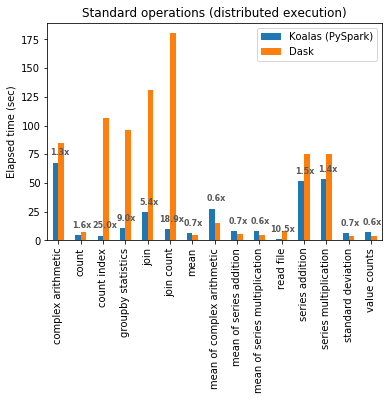

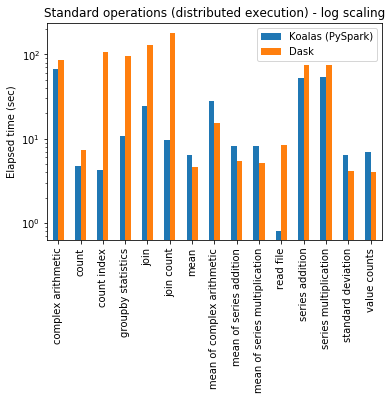

Text(0, 0.5, 'Elapsed time (sec)')

In [0]:
plot_title = 'Standard operations (distributed execution)'

ax = standard_ops.sort_index().plot.bar(title=plot_title)
ax.set_ylabel("Elapsed time (sec)")

tmp_df_x_times_faster = standard_ops.sort_index().copy()
tmp_df_x_times_faster['Dask / Koalas'] = tmp_df_x_times_faster.Dask / tmp_df_x_times_faster['Koalas (PySpark)']
tmp_df_x_times_faster['Koalas / Dask'] = tmp_df_x_times_faster['Koalas (PySpark)'] / tmp_df_x_times_faster.Dask
annotate_x_times_faster(ax, x_times_list=tmp_df_x_times_faster['Dask / Koalas'].to_list())

standard_ops.sort_index().plot.bar(logy=True, title='%s - log scaling' % plot_title).set_ylabel("Elapsed time (sec)")

In [0]:
tmp_df_x_times_faster

Out[4]:

,Koalas (PySpark),Dask,Dask / Koalas,Koalas / Dask
complex arithmetic,67.688566,85.001121,1.255768,0.796326
count,4.781610,7.414245,1.550575,0.644922
count index,4.269476,106.659126,24.981783,0.040029
groupby statistics,10.677163,95.983826,8.989637,0.111239
join,24.347107,130.850126,5.374360,0.186069
join count,9.523618,180.246591,18.926273,0.052837
mean,6.393266,4.559931,0.713240,1.402053
mean of complex arithmetic,27.711828,15.523434,0.560174,1.785161
mean of series addition,8.099924,5.478110,0.676316,1.478598
mean of series multiplication,8.210824,5.156972,0.628070,1.592179


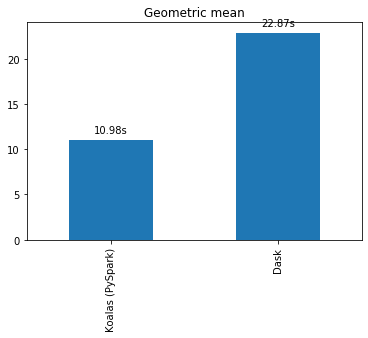

In [0]:
annotate(pd.Series(stats.gmean(standard_ops), index=['Koalas (PySpark)', 'Dask']).plot.bar(title='Geometric mean'))

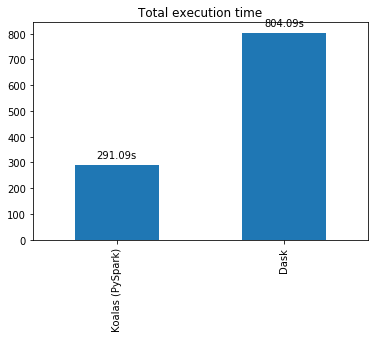

In [0]:
annotate(standard_ops.sum().plot.bar(title='Total execution time'))

In [0]:
print("Performance diff %% (simple avg): %s" % (sum(standard_ops.Dask / standard_ops['Koalas (PySpark)']) / len(standard_ops)))
print("Performance diff %% (geomean): %s" % stats.gmean(standard_ops.Dask / standard_ops['Koalas (PySpark)']))

Performance diff % (simple avg): 5.214644918097563
Performance diff % (geomean): 2.0831778574368713

### Operations with filtering

Out[8]:

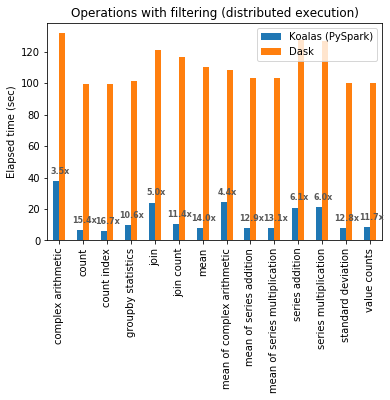

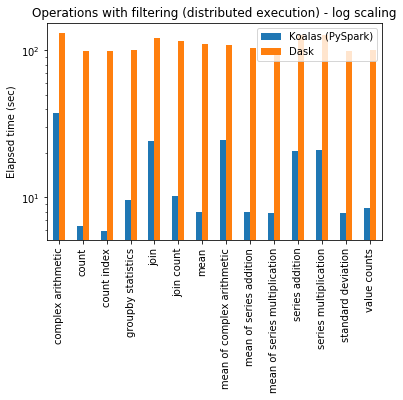

Text(0, 0.5, 'Elapsed time (sec)')

In [0]:
plot_title = 'Operations with filtering (distributed execution)'

ax = ops_with_filtering.sort_index().plot.bar(title=plot_title)
ax.set_ylabel("Elapsed time (sec)")

tmp_df_x_times_faster = ops_with_filtering.sort_index().copy()
tmp_df_x_times_faster['Dask / Koalas'] = tmp_df_x_times_faster.Dask / tmp_df_x_times_faster['Koalas (PySpark)']
tmp_df_x_times_faster['Koalas / Dask'] = tmp_df_x_times_faster['Koalas (PySpark)'] / tmp_df_x_times_faster.Dask
annotate_x_times_faster(ax, x_times_list=tmp_df_x_times_faster['Dask / Koalas'].to_list())

ops_with_filtering.sort_index().plot.bar(logy=True, title='%s - log scaling' % plot_title).set_ylabel("Elapsed time (sec)")

In [0]:
tmp_df_x_times_faster

Out[9]:

,Koalas (PySpark),Dask,Dask / Koalas,Koalas / Dask
complex arithmetic,37.653965,131.661028,3.496605,0.285992
count,6.441401,99.274989,15.412018,0.064884
count index,5.954340,99.403733,16.694333,0.059901
groupby statistics,9.574535,101.388170,10.589357,0.094434
join,24.061276,121.262373,5.039732,0.198423
join count,10.205025,116.561164,11.421938,0.087551
mean,7.919041,110.492872,13.952810,0.071670
mean of complex arithmetic,24.441328,108.534629,4.440619,0.225194
mean of series addition,7.988557,103.131108,12.909854,0.077460
mean of series multiplication,7.877638,103.350701,13.119504,0.076222


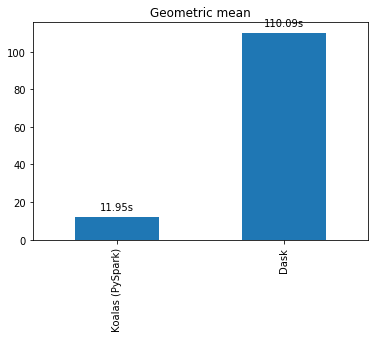

In [0]:
annotate(pd.Series(stats.gmean(ops_with_filtering), index=['Koalas (PySpark)', 'Dask']).plot.bar(title='Geometric mean'))

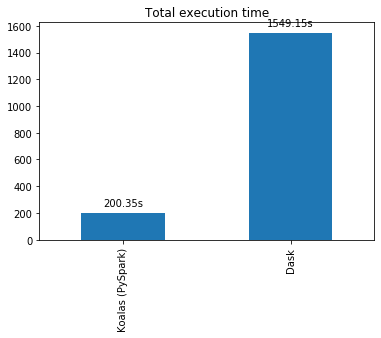

In [0]:
annotate(ops_with_filtering.sum().plot.bar(title='Total execution time'))

In [0]:
print("Performance diff %% (simple avg): %s" % (sum(ops_with_filtering.Dask / ops_with_filtering['Koalas (PySpark)']) / len(ops_with_filtering)))
print("Performance diff %% (geomean): %s" % stats.gmean(ops_with_filtering.Dask / ops_with_filtering['Koalas (PySpark)']))

Performance diff % (simple avg): 10.264825867300187
Performance diff % (geomean): 9.21307241418659

## Operations with filtering and caching

Added caching for the filtered data.

Out[13]:

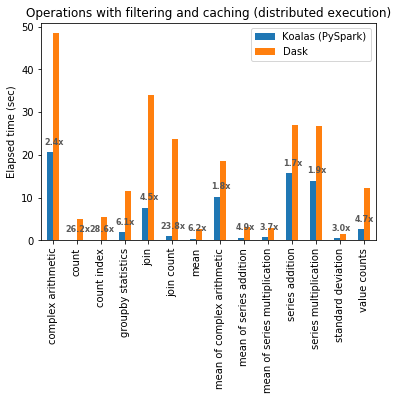

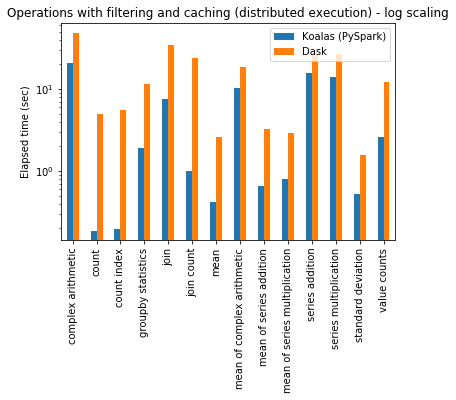

Text(0, 0.5, 'Elapsed time (sec)')

In [0]:
plot_title = 'Operations with filtering and caching (distributed execution)'

ax = ops_with_filtering_caching.sort_index().plot.bar(title=plot_title)
ax.set_ylabel("Elapsed time (sec)")

tmp_df_x_times_faster = ops_with_filtering_caching.sort_index().copy()
tmp_df_x_times_faster['Dask / Koalas'] = tmp_df_x_times_faster.Dask / tmp_df_x_times_faster['Koalas (PySpark)']
tmp_df_x_times_faster['Koalas / Dask'] = tmp_df_x_times_faster['Koalas (PySpark)'] / tmp_df_x_times_faster.Dask

annotate_x_times_faster(ax, x_times_list=tmp_df_x_times_faster['Dask / Koalas'].to_list())

ops_with_filtering_caching.sort_index().plot.bar(logy=True, title='%s - log scaling' % plot_title).set_ylabel("Elapsed time (sec)")

In [0]:
tmp_df_x_times_faster

Out[14]:

,Koalas (PySpark),Dask,Dask / Koalas,Koalas / Dask
complex arithmetic,20.591080,48.436886,2.352324,0.425112
count,0.187099,4.907020,26.226869,0.038129
count index,0.193122,5.515225,28.558221,0.035016
groupby statistics,1.895659,11.602865,6.120754,0.163379
join,7.651796,34.071718,4.452774,0.224579
join count,0.998765,23.809839,23.839278,0.041948
mean,0.422080,2.630737,6.232786,0.160442
mean of complex arithmetic,10.215212,18.545564,1.815485,0.550817
mean of series addition,0.661349,3.256518,4.924055,0.203085
mean of series multiplication,0.801396,2.941072,3.669938,0.272484


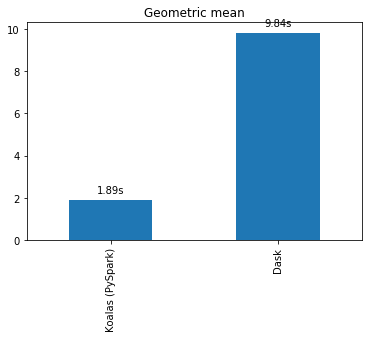

In [0]:
annotate(pd.Series(stats.gmean(ops_with_filtering_caching), index=['Koalas (PySpark)', 'Dask']).plot.bar(title='Geometric mean'))

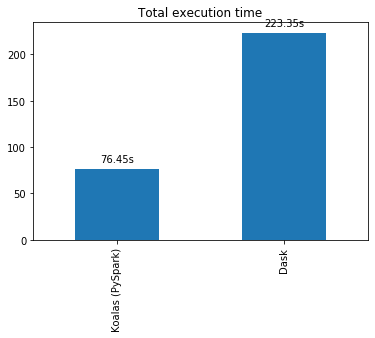

In [0]:
annotate(ops_with_filtering_caching.sum().plot.bar(title='Total execution time'))

In [0]:
print("Performance diff %% (simple avg): %s" % (sum(ops_with_filtering_caching.Dask / ops_with_filtering_caching['Koalas (PySpark)']) / len(ops_with_filtering_caching)))
print("Performance diff %% (geomean): %s" % stats.gmean(ops_with_filtering_caching.Dask / ops_with_filtering_caching['Koalas (PySpark)']))

Performance diff % (simple avg): 8.536061411618467
Performance diff % (geomean): 5.207452248469939

## Overall

In [0]:
overall_df = pd.concat([standard_ops, ops_with_filtering, ops_with_filtering_caching])
print("Total performance diff %% (simple avg): %s" % (sum(overall_df.Dask / overall_df['Koalas (PySpark)']) / len(overall_df)))
print("Total performance diff %% (geomean): %s" % stats.gmean(overall_df.Dask / overall_df['Koalas (PySpark)']))

Total performance diff % (simple avg): 7.940281294798245
Total performance diff % (geomean): 4.555076052145392